In [1]:
# HIDDEN CELL
import sys, os

import numpy as np

# Importing argopy in dev mode:
on_rtd = os.environ.get('READTHEDOCS', None) == 'True'
if not on_rtd:
    sys.path.insert(0, "/Users/gmaze/git/github/euroargodev/argopy")
    import git
    import argopy
    from argopy.options import OPTIONS
    print("argopy:", argopy.__version__, 
          "\nsrc:", argopy.__file__, 
          "\nbranch:", git.Repo(search_parent_directories=True).active_branch.name, 
          "\noptions:", OPTIONS)
else:
    sys.path.insert(0, os.path.abspath('..'))

import xarray as xr
# xr.set_options(display_style="html");
xr.set_options(display_style="text");

argopy: 0.1.6 
src: /Users/gmaze/git/github/euroargodev/argopy/argopy/__init__.py 
branch: parallel-requests 
options: {'src': 'erddap', 'local_ftp': '.', 'dataset': 'phy', 'cachedir': '/Users/gmaze/.cache/argopy', 'mode': 'standard', 'api_timeout': 60}


In [2]:
import argopy
from argopy import DataFetcher as ArgoDataFetcher

# Performance

To improve ``argopy`` data fetching performances (in terms of time of retrieval), 2 solutions are available:
    
- Cache fetched data, i.e. save your request locally so that you don't have to fetch it again,
- Fetch data by chunks in parallel, i.e. fetch peace of independant data simultaneously.

These solutions are explained below.

Note that another solution from standard big data strategies would be to fetch data lazily. But since (i) *argopy* post-processes raw Argo data on the client side and (ii) none of the data sources are cloud/lazy compatible, this solution is not possible (yet).

## Cache

### Caching data

If you want to avoid retrieving the same data several times during a working session, or if you fetched a large amount of data, you may want to temporarily save data in a cache file.

You can cache fetched data with the fetchers option ``cache``.

**Argopy** cached data are persistent, meaning that they are stored locally on files and will survive execution of your script with a new session. 
**Cached data have an expiration time of one day**, since this is the update frequency of most data sources. This will ensure you always have the last version of Argo data.

All data and meta-data (index) fetchers have a caching system.

The argopy default cache folder is under your home directory at ``~/.cache/argopy``. 

But you can specify the path you want to use in several ways:

- with **argopy** global options:

```python
argopy.set_options(cachedir='mycache_folder')
```

- in a temporary context:

```python
with argopy.set_options(cachedir='mycache_folder'):
    ds = ArgoDataFetcher(cache=True).profile(6902746, 34).to_xarray()
```

- when instantiating the data fetcher:

```python
ds = ArgoDataFetcher(cache=True, cachedir='mycache_folder').profile(6902746, 34).to_xarray()
```

### Clearing the cache

If you want to manually clear your cache folder, and/or make sure your data are newly fetched, you can do it at the fetcher level with the ``clear_cache`` method.

Start to fetch data and store them in cache:

```python
fetcher = ArgoDataFetcher(cache=True, cachedir='mycache_folder').profile(6902746, 34)
fetcher.to_xarray();
```

Fetched data are in the local cache folder:
```python
os.listdir('mycache_folder')
```
```bash
['cache', 
 'c5c820b6aff7b2ef86ef00626782587a95d37edc54120a63ee4699be2b0c6b7c']
```

where we see one hash entries the newly fetched data and the cache registry file ``cache``.

We can then fetch something else using the same cache folder:

```python
fetcher2 = ArgoDataFetcher(cache=True, cachedir='mycache_folder').profile(1901393, 1)
fetcher2.to_xarray();
```

All fetched data are cached:

```python
os.listdir('mycache_folder')
```
```bash
['cache',
 'c5c820b6aff7b2ef86ef00626782587a95d37edc54120a63ee4699be2b0c6b7c',
 '58072df8477157c194449a2e6dff8d69ca3c8fded01eebdd8a5fc446f2f7f9a7']
```

Note the new hash file with the ``fetcher2`` data.

It is important to note that we can safely clear the cache from the first ``fetcher`` data, it won't remove the ``fetcher2`` data:

```python
fetcher.clear_cache()
os.listdir('mycache_folder')
```
```bash
['cache', 
 '58072df8477157c194449a2e6dff8d69ca3c8fded01eebdd8a5fc446f2f7f9a7']
```

By using the fetcher level clear cache, you make sure that only data fetched with it are removed, while other fetched data (with other fetchers for instance) will stay in place.

If you want to clear the entire cache folder, whatever the fetcher used, do it at the package level with:

```python
argopy.clear_cache()
```

So, if we now check the cache folder, it's been deleted:

```python
os.listdir('mycache_folder')
```
```bash
---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
<ipython-input-13-6726e674f21f> in <module>
----> 1 os.listdir('mycache_folder')

FileNotFoundError: [Errno 2] No such file or directory: 'mycache_folder'
```

## Parallel data fetching

Sometimes you may find that your request takes a long time to fetch, or simply does not even succeed. This is probably because you're trying to fetch a large amount of data.

In this case, you can try to let argopy chunks your request into smaller pieces and have them fetched in parallel for you. This is done with the argument ``parallel`` of the data fetcher and can be tuned using options ``chunks`` and ``chunksize``.

This goes by default like this:

In [3]:
# Define a box to load (large enough to trigger chunking):
box = [-60, -30, 40.0, 60.0, 0.0, 100.0, "2007-01-01", "2007-04-01"]

# Instantiate a parallel fetcher:
loader_par = ArgoDataFetcher(src='erddap', parallel=True).region(box)

you can also use the option ``progress`` to display a progress bar during fetching:

In [4]:
loader_par = ArgoDataFetcher(src='erddap', parallel=True, progress=True).region(box)
loader_par

<datafetcher.erddap>
Name: Ifremer erddap Argo data fetcher for a space/time region
API: https://www.ifremer.fr/erddap
Domain: [x=-60.00/-30.00; y=40.00/60.0 ... 00.0; t=2007-01-01/2007-04-01]
Backend: erddap (parallel=True)
User mode: standard

Then, you can fetch data as usual:

In [5]:
%%time
ds = loader_par.to_xarray()

100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


CPU times: user 727 ms, sys: 108 ms, total: 836 ms
Wall time: 1.33 s


### Number of chunks

To check how many chunks your request has been split into, you can look at the ``uri`` property of the fetcher, it gives you the list of paths toward data:

In [6]:
# Display only the relevant part of each URLs of URI:
for uri in loader_par.uri:
    print("http: ... ", "&".join(uri.split("&")[1:-2])) 

http: ...  longitude>=-60.0&longitude<=-45.0&latitude>=40.0&latitude<=60.0&pres>=0.0&pres<=100.0&time>=1167609600.0&time<=1175385600.0
http: ...  longitude>=-45.0&longitude<=-30.0&latitude>=40.0&latitude<=60.0&pres>=0.0&pres<=100.0&time>=1167609600.0&time<=1175385600.0


To control chunking, you can use the **``chunks``** option that specifies the number of chunks in each of the *direction*:

- ``lon``, ``lat``, ``dpt`` and ``time`` for a **region** fetching,
- ``wmo`` for a **float** and **profile** fetching.

In [7]:
# Create a large box:
box = [-60, 0, 0.0, 60.0, 0.0, 500.0, "2007", "2010"]

# Init a parallel fetcher:
loader_par = ArgoDataFetcher(src='erddap', 
                             parallel=True, 
                             chunks={'lon': 5}).region(box)
# Check number of chunks:
len(loader_par.uri)

195

This creates 195 chunks, and 5 along the longitudinale direction, as requested. 

When the ``chunks`` option is not specified for a given *direction*, it relies on auto-chunking using pre-defined chunk maximum sizes (see below). 
In the case above, this explains why we have 195 and not only 5 chunks.

To chunk the request along a single direction, set explicitely all the others direction to ``1``:

In [8]:
# Init a parallel fetcher:
loader_par = ArgoDataFetcher(src='erddap', 
                             parallel=True, 
                             chunks={'lon': 5, 'lat':1, 'dpt':1, 'time':1}).region(box)

# Check number of chunks:
len(loader_par.uri)

5

We now have 5 chunks along longitude, check out the URLs parameter in the list of URIs:

In [9]:
for uri in loader_par.uri:
    print("&".join(uri.split("&")[1:-2])) # Display only the relevant URL part

longitude>=-60.0&longitude<=-48.0&latitude>=0.0&latitude<=60.0&pres>=0.0&pres<=500.0&time>=1167609600.0&time<=1262304000.0
longitude>=-48.0&longitude<=-36.0&latitude>=0.0&latitude<=60.0&pres>=0.0&pres<=500.0&time>=1167609600.0&time<=1262304000.0
longitude>=-36.0&longitude<=-24.0&latitude>=0.0&latitude<=60.0&pres>=0.0&pres<=500.0&time>=1167609600.0&time<=1262304000.0
longitude>=-24.0&longitude<=-12.0&latitude>=0.0&latitude<=60.0&pres>=0.0&pres<=500.0&time>=1167609600.0&time<=1262304000.0
longitude>=-12.0&longitude<=0.0&latitude>=0.0&latitude<=60.0&pres>=0.0&pres<=500.0&time>=1167609600.0&time<=1262304000.0


### Size of chunks

The default chunk size for each access point dimensions are:

| Access point dimension | Maximum chunk size |
|------------------------|:------------------:|
| region / **lon**       |       20 deg       |
| region / **lat**       |       20 deg       |
| region / **dpt**       |      500 m or db   |
| region / **time**      |       90 days      |
| float / **wmo**        |          5         |
| profile / **wmo**      |          5         |

These default values are used to chunk data where the ``chunks`` parameter key is set to ``auto``.

But you can modify the maximum chunk size allowed in each of the possible directions. This is done with the option **``chunks_maxsize``**.

For instance if you want to make sure that your chunks are not larger then 100 meters (db) in depth (pressure), you can use:

In [10]:
# Create a large box:
box = [-60, -10, 40.0, 60.0, 0.0, 500.0, "2007", "2010"]

# Init a parallel fetcher:
loader_par = ArgoDataFetcher(src='erddap', 
                             parallel=True, 
                             chunks_maxsize={'dpt': 100}).region(box)
# Check number of chunks:
len(loader_par.uri)

195

Since this creates a large number of chunks, let's do this again and combine with the option ``chunks`` to see easily what's going on:

In [11]:
# Init a parallel fetcher with chunking along the vertical axis alone:
loader_par = ArgoDataFetcher(src='erddap', 
                             parallel=True, 
                             chunks_maxsize={'dpt': 100},
                             chunks={'lon':1, 'lat':1, 'dpt':'auto', 'time':1}).region(box)

for uri in loader_par.uri:
    print("http: ... ", "&".join(uri.split("&")[1:-2])) # Display only the relevant URL part

http: ...  longitude>=-60&longitude<=-10&latitude>=40.0&latitude<=60.0&pres>=0.0&pres<=100.0&time>=1167609600.0&time<=1262304000.0
http: ...  longitude>=-60&longitude<=-10&latitude>=40.0&latitude<=60.0&pres>=100.0&pres<=200.0&time>=1167609600.0&time<=1262304000.0
http: ...  longitude>=-60&longitude<=-10&latitude>=40.0&latitude<=60.0&pres>=200.0&pres<=300.0&time>=1167609600.0&time<=1262304000.0
http: ...  longitude>=-60&longitude<=-10&latitude>=40.0&latitude<=60.0&pres>=300.0&pres<=400.0&time>=1167609600.0&time<=1262304000.0
http: ...  longitude>=-60&longitude<=-10&latitude>=40.0&latitude<=60.0&pres>=400.0&pres<=500.0&time>=1167609600.0&time<=1262304000.0


You can see, that the ``pres`` argument of this erddap list of URLs define layers not thicker than the requested 100db.

With the ``profile`` and ``float`` access points, you can use the ``wmo`` keyword to control the number of WMOs in each chunks.

In [12]:
WMO_list = [6902766, 6902772, 6902914, 6902746, 6902916, 6902915, 6902757, 6902771]

# Init a parallel fetcher with chunking along the list of WMOs:
loader_par = ArgoDataFetcher(src='erddap', 
                             parallel=True, 
                             chunks_maxsize={'wmo': 3}).float(WMO_list)

for uri in loader_par.uri:
    print("http: ... ", "&".join(uri.split("&")[1:-2])) # Display only the relevant URL part

http: ...  platform_number=~"6902766|6902772|6902914"
http: ...  platform_number=~"6902746|6902916|6902915"
http: ...  platform_number=~"6902757|6902771"


You see here, that this request for 8 floats is split in chunks with no more that 3 floats each.

### Parallelization methods

They are 2 methods available to set-up your data fetching requests in parallel:
    
1. [Multi-threading](https://en.wikipedia.org/wiki/Multithreading_(computer_architecture)) for all data sources,
1. [Multi-processing](https://en.wikipedia.org/wiki/Multiprocessing) for *localftp*.

Both options use a pool of [threads](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.ThreadPoolExecutor) or [processes](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.ProcessPoolExecutor) managed with the [concurrent futures module](https://docs.python.org/3/library/concurrent.futures.html#module-concurrent.futures). 

The parallelization method is set with the ``parallel_method`` option of the fetcher, which can take as values ``thread`` or ``process``.

Methods available for data sources:

| **Parallel method**     | erddap | localftp | argovis |
|-------------------------|:------:|:--------:|:-------:|
| Multi-threading         |    X   |     X    |    X    |
| Multi-processes         |        |     X    |         |

Note that you can in fact pass the method directly with the ``parallel`` option, so that in practice, these two formulations are equivalent:
```python
ArgoDataFetcher(parallel=True, parallel_method='thread')
ArgoDataFetcher(parallel='thread')
```

### Comparison of performances

Note that to compare performances with or without the parallel option, we need to make sure that data are not cached on the server side.
To do this, we use a very small random perturbation on the box definition, here on the maximum latitude.

In [13]:
def this_box():
    return [-60, 0, 
           20.0, 60.0 + np.random.randint(0,100,1)[0]/1000, 
           0.0, 500.0, 
           "2007", "2009"]

In [14]:
%%time
b1 = this_box()
f1 = ArgoDataFetcher(src='argovis', parallel=False).region(b1)
ds1 = f1.to_xarray()

CPU times: user 6.51 s, sys: 954 ms, total: 7.46 s
Wall time: 36.6 s


In [15]:
%%time
b2 = this_box()
f2 = ArgoDataFetcher(src='argovis', parallel=True).region(b2)
ds2 = f2.to_xarray(errors='raise')

CPU times: user 7.01 s, sys: 873 ms, total: 7.88 s
Wall time: 10.4 s


**This simple comparison shows that parallel request is significantly faster than the standard one.**

In [16]:
print("Nb of points in each returned dataset (without/with parallel fetching:)")
np.max(ds1['N_POINTS'].values), np.max(ds2['N_POINTS'].values)

Nb of points in each returned dataset (without/with parallel fetching:)


(586846, 586473)

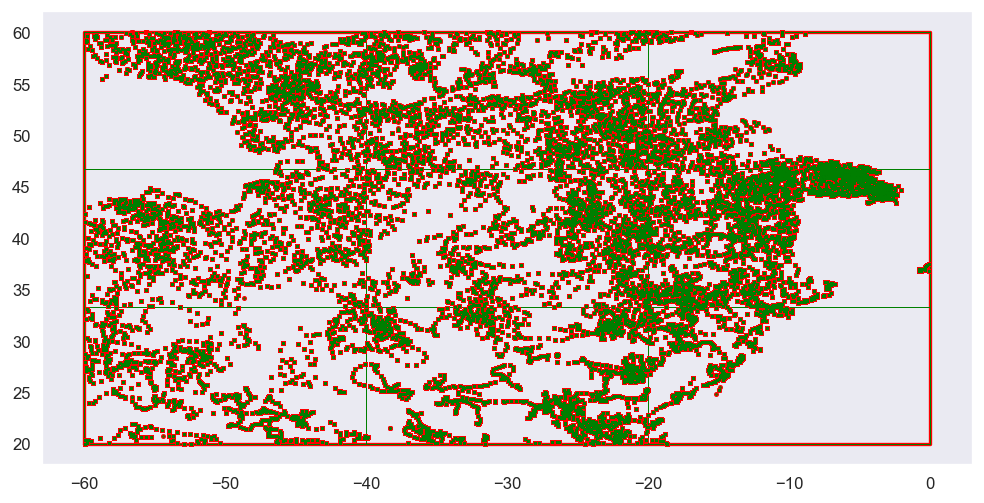

In [17]:
import matplotlib.pyplot as plt

def plot_box(b, ax, c='k', lw=1):
    return ax.plot([b[0], b[1], b[1], b[0], b[0]],[b[2], b[2], b[3], b[3], b[2]], color=c, linewidth=lw)

fig, ax = plt.subplots(ncols=1, nrows=1, dpi=120, figsize=(10,5))
plot_box(b1, ax, c='r', lw=2)
for b in f2.fetcher.Chunker.fit_transform():
    plot_box(b, ax, c='g', lw=0.5)
ax.plot(ds1['LONGITUDE'], ds1['LATITUDE'], 'ro', markersize=2)
ax.plot(ds2['LONGITUDE'], ds2['LATITUDE'], 'g.', markersize=1)

### Warnings

- Parallelizing your fetcher is usefull to handle large region of data, but it can also add a significant overhead on *reasonable* size requests that may lead to degraded performances. So, we do not recommand for you to use the parallel option systematically.

- You may have different dataset sizes with and without the ``parallel`` option. This may happen if one of the chunk data fetching fails. By default, data fetching of multiple ressources fails silently with a warning. You can change this behaviour with the option ``errors`` of the ``to_xarray()`` fetcher methods, just set it to ``raise`` like this:

```python
ArgoDataFetcher(parallel=True).region(this_box()).to_xarray(errors='raise');
```